<a href="https://colab.research.google.com/github/hucarlos08/Nerf-Geo/blob/main/NeRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nerfstudio

# NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis

The idea proposed in the paper [**NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis**](https://arxiv.org/abs/2003.08934) aims to generate new views of an object (or even better, of a scene) using deep learning and computer graphics concepts. To better understand the idea, we first need to understand how information is captured in an image ([Ref](https://www.cambridge.org/core/books/multiple-view-geometry-in-computer-vision/0B6F289C78B2B23F596CAA76D3D43F7A)).

| ![2d-train](https://imgur.com/YnYO9Zd.gif) |
| :---: |
| **Figure 1**: The idea. |

## Introduction to NeRF

Neural Radiance Fields (NeRF) is a recent advancement in the field of computer graphics and vision. It enables the creation of realistic 3D scenes from 2D images by representing scenes as neural networks. NeRF uses deep learning to synthesize novel views of a scene with high quality and detail.

## Motivation

Traditional methods for view synthesis rely on geometric representations or multi-view stereo techniques. NeRF leverages neural networks to learn a continuous volumetric scene function, providing a more flexible and powerful approach.

In this notebook, we will explore the fundamental concepts of NeRF, including its mathematical foundations, neural network architecture, and training process.


## NeRF Input: Images and Camera Poses

The NeRF algorithm requires two key inputs:

1. **A Set of Images:** These images should capture the scene from different viewpoints, ideally with some overlap between the views. The more images you have, and the more diverse their viewpoints, the better NeRF can reconstruct the scene.

2. **Camera Poses:** For each image, you need to know the position and orientation of the camera in the 3D world. This information, often represented as a 4x4 transformation matrix, tells NeRF where the camera was located and how it was pointing when the image was taken.

**Obtaining Camera Poses**

In many real-world scenarios, camera pose information isn't readily available. However, there are several techniques to estimate it:

* **Visual SLAM (Simultaneous Localization and Mapping):**  This family of algorithms allows a camera to simultaneously build a map of its environment and track its own location within that map.
* **Structure from Motion (SfM):**  SfM algorithms analyze a set of images to reconstruct the 3D structure of the scene and the camera poses.
* **Deep Learning-Based Methods:** Recent advances in deep learning have led to powerful methods for estimating camera poses directly from images.

**Tools for Estimating Camera Poses**

Here are some popular tools for estimating camera poses, listed in order of recommendation:

1. **[COLMAP:](https://colmap.github.io/)** A state-of-the-art photogrammetry software that excels at reconstructing 3D scenes and estimating camera poses from images. It's known for its accuracy and robustness.

2. **[Meshroom:](https://alicevision.org/)** An open-source photogrammetry software that provides a user-friendly interface for 3D reconstruction and camera pose estimation.

3. **[OpenCV](https://docs.opencv.org/3.4/de/d7c/tutorial_table_of_content_sfm.html):** A versatile computer vision library that includes functions for camera calibration and pose estimation.

4. **[Matlab](https://la.mathworks.com/help/vision/ug/structure-from-motion-from-multiple-views.html):** A commercial software with a Computer Vision Toolbox that offers functions for camera calibration and structure from motion.

**Choosing the Right Tool**

The best tool for you will depend on your specific needs and expertise. COLMAP is generally considered the most accurate, but it can have a steeper learning curve. Meshroom is a good option for beginners, while OpenCV and MATLAB offer more flexibility for experienced users.

**Additional Considerations**

* **Image Quality:**  High-quality images with good lighting and minimal motion blur will lead to better camera pose estimates and, ultimately, better NeRF reconstructions.
* **Scene Complexity:** Complex scenes with lots of occlusions or repetitive patterns can be challenging for camera pose estimation.
* **Calibration:**  If you're using a real camera, it's essential to calibrate it to ensure accurate pose estimation.



--2024-05-15 12:20:24--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-05-15 12:20:25--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  16.3MB/s    in 0.7s    

2024-05-15 12:20:29 (16.3 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]

Images shape: (106, 100, 100, 3)
Poses shape: (106, 4, 4)
Focal length: 138.88887889922103
Pose
[[-0.12173834  0.6862695  -0.7170871  -2.890670

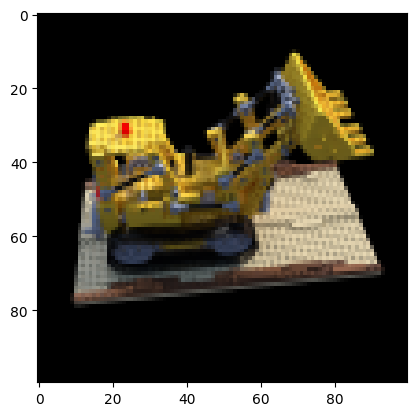

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

if not os.path.exists('tiny_nerf_data.npz'):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

print(f'Images shape: {images.shape}')
print(f'Poses shape: {poses.shape}')
print(f'Focal length: {focal}')

height, width = images.shape[1:3]

testimg_idx = 5
testimg, testpose = images[testimg_idx], poses[testimg_idx]

plt.imshow(testimg)
print('Pose')
print(testpose)

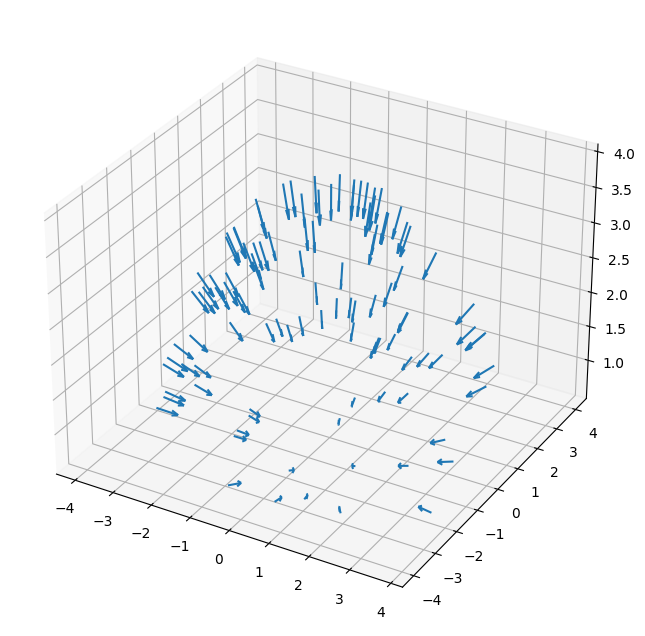

In [2]:
dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in poses])
origins = poses[:, :3, -1]

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
_  = ax.quiver(
  origins[..., 0].flatten(),
  origins[..., 1].flatten(),
  origins[..., 2].flatten(),
  dirs[..., 0].flatten(),
  dirs[..., 1].flatten(),
  dirs[..., 2].flatten(), length=0.5, normalize=True)
plt.show()

## Pipeline

| ![Nerf-met](https://imgur.com/s9hq0J1.png) |
| :---: |
| **Figure 2**: NeRF pipeline. |

### 1. Rays

**1.1 Ray Generation**

* **Purpose:** Rays are the fundamental building blocks of NeRF's rendering process. They represent lines of sight originating from the camera and passing through each pixel in the image.
* **Generation:** Rays are generated based on the camera's pose (position and orientation) and the intrinsic parameters (focal length, etc.). Each ray is defined by its origin (the camera's position) and direction.
* **Sampling Strategies:**
    * **Stratified Sampling:** Divides the image plane into regular grids and samples rays randomly within each grid cell, ensuring even coverage.
    * **Importance Sampling:**  Samples rays more densely in regions where the scene is expected to have more detail or variation, improving efficiency.

**1.2 Ray Sampling**

* **Purpose:** Once rays are generated, we need to sample points along each ray to query the NeRF model and determine the color and density at those points.
* **Strategies:**
    * **Uniform Sampling:** Samples points at equal distances along the ray.
    * **Hierarchical Sampling:** Adaptively samples more points in regions where the scene changes rapidly.

### 2. Constructing the NeRF Model ($F_\Theta$)

* **Architecture:** NeRF is typically implemented as a Multilayer Perceptron (MLP) neural network. The input to the network is a 5D vector representing the 3D coordinates of a point along a ray and the 2D viewing direction. The output is a 4D vector representing the color (RGB) and density (sigma) at that point.
* **Training:** The network is trained on a dataset of images and their corresponding camera poses. The goal is to learn a mapping from 5D input coordinates to color and density values that accurately reproduce the input images.

### 3. Volumetric Rendering

* **Purpose:** To determine the final color of each pixel in the image, we need to integrate the color and density values along each ray. This process is known as volumetric rendering.
* **Numerical Integration:**  Since the NeRF model represents a continuous function, we use numerical integration techniques (e.g., quadrature) to approximate the integral of color and density along each ray.

### 4. Loss Function (Photometric Loss)

* **Purpose:** The loss function measures the difference between the rendered image produced by the NeRF model and the corresponding ground truth image. This guides the training process, encouraging the model to produce images that closely match the real world.
* **Photometric Loss:**  A common choice for the loss function is the mean squared error (MSE) between the rendered and ground truth pixel colors. This encourages the model to minimize the difference in color across all pixels.

**Additional Considerations:**

* **Regularization:**  To prevent overfitting, regularization techniques like weight decay or early stopping can be applied during training.
* **Optimization:**  The model is typically optimized using gradient descent or a variant like Adam. The gradients of the loss function with respect to the model parameters are computed using backpropagation and automatic differentiation (enabled by frameworks like JAX).




## Rays

#### Generation

The goal is to create *rays* that intersect the volume we want to reconstruct (the scene).


| ![Nerf-ray](https://imgur.com/MF39ucD.png=50x50) |
| :---: |
| **Figure 2**: NeRF rays. |

Using classical definitions from computational geometry, we can define a ray as:

$$
\vec{r}(t) = \vec{o} + t\vec{d}
$$

Where:

1.  $\vec{r}(t)$ is the ray.
2.  $\vec{d}$ is the unit vector representing the ray's direction.
3.  $\vec{o}$ is the ray's origin.
4.  $t$ is a parameter (e.g., time).

**In the context of NeRF:**

*   The **origin** of the ray ($\vec{o}$) is the position of a pixel on the image plane.
*   The **direction** ($\vec{d}$) is the line connecting the pixel to the camera's aperture.

**Calculating Ray Direction**

To calculate the ray direction, we need to consider the camera's extrinsic matrix ($C_{ext}$), which describes the camera's position and orientation in the world coordinate system.

1. **Pixel Coordinates to Camera Coordinates:**
   First, we convert pixel coordinates $(u, v)$ to camera coordinates $(x_c, y_c, z_c)$ using the camera's intrinsic parameters (focal length '$f$' and principal point offsets $\delta_x$, $\delta_y$):

$$
\begin{align*}
u &= f \frac{x_c}{z_c} + \delta_x \quad \Rightarrow \quad x_c = z_c \frac{u - \delta_x}{f} \\
v &= f \frac{y_c}{z_c} + \delta_y \quad \Rightarrow \quad y_c = z_c \frac{v - \delta_y}{f}
\end{align*}
$$
We can assume $z_c = 1$ for simplicity.

2. **Camera Coordinates to World Coordinates:**
   Next, we transform the camera coordinates into world coordinates using the inverse of the camera's extrinsic matrix ($C_{ext}^{-1}$):

$$
\tilde{X}_w = C_{ext}^{-1} \times \tilde{X}_c
$$

Where:

$$
C_{ext}^{-1} = \begin{bmatrix} r_{11}' & r_{12}' & r_{13}' & t_x' \\ r_{21}' & r_{22}' & r_{23}' & t_y' \\ r_{31}' & r_{32}' & r_{33}' & t_z' \\ 0 & 0 & 0 & 1 \end{bmatrix}
$$

3. **Ray Direction:**
   Since we're only interested in the direction, we normalize the resulting vector:

$$
\vec{d} = \frac{R_{ext}' \times X_c}{||R_{ext}' \times X_c||}
$$
Where $R_{ext}'$ is the rotation part of $C_{ext}^{-1}$.

**Ray Origin**

The origin of the ray ($\vec{o}$) is simply the translation component of the camera's extrinsic matrix:

$$
\vec{o} = \begin{bmatrix} t_x' \\ t_y' \\ t_z' \end{bmatrix}
$$


In [10]:
# COLLAPSED

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch
from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.utils import plotly_utils as vis
from nerfstudio.model_components import ray_samplers


# Define the layout for the 3D plots
webdocs_layout = dict(
    aspectmode="data",
    xaxis=dict(showspikes=False),
    yaxis=dict(showspikes=False),
    zaxis=dict(showspikes=False),
    xaxis_visible=False,
    yaxis_visible=False,
    zaxis_visible=False,
    camera=dict(up=dict(x=0, y=1, z=0)),
)

# Camera and ray setup
cx = 2.0
cy = 2.0
fx = 10.0
fy = 10.0

num_samples = 3
near_plane = 1
far_plane = 3

c2w = torch.eye(4)[None, :3, :]
camera = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.PERSPECTIVE)
ray_bundle = camera.generate_rays(camera_indices=0)

bins = torch.linspace(near_plane, far_plane, num_samples + 1)[..., None]
ray_samples = ray_bundle.get_ray_samples(bin_starts=bins[:-1, :], bin_ends=bins[1:, :])

vis_rays = vis.get_ray_bundle_lines(ray_bundle, color="teal", length=far_plane)

# Create subplots
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=("Frustums Mesh", "Frustum Points", "Gaussian Ellipsoids")
)

# Add traces for the first plot
frustums_mesh_list = vis.get_frustums_mesh_list(ray_samples.frustums)
for mesh in frustums_mesh_list:
    fig.add_trace(mesh, row=1, col=1)
fig.add_trace(vis_rays, row=1, col=1)

# Add traces for the second plot
frustum_points = vis.get_frustum_points(ray_samples.frustums)
fig.add_trace(frustum_points, row=1, col=2)
fig.add_trace(vis_rays, row=1, col=2)

# Add traces for the third plot
gaussian_ellipsoids_list = vis.get_gaussian_ellipsoids_list(ray_samples.frustums.flatten().get_gaussian_blob())
for ellipsoid in gaussian_ellipsoids_list:
    fig.add_trace(ellipsoid, row=1, col=3)
fig.add_trace(vis_rays, row=1, col=3)

# Update layout for each subplot individually
fig.update_scenes(webdocs_layout, row=1, col=1)
fig.update_scenes(webdocs_layout, row=1, col=2)
fig.update_scenes(webdocs_layout, row=1, col=3)



fig.show()

/usr/local/lib/python3.10/dist-packages/nerfstudio/utils/plotly_utils.py:399: UserWarning:

Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:63.)



#### Ray Sampling

After **ray generation**, we need to sample 3D points along each ray. These sampled points are where we'll query the NeRF model to determine the color and density of the scene at those locations. There are two primary approaches to this:

1.  **Uniform Sampling:**
    *   **Concept:** As the name suggests, this method samples points at equal intervals along the ray. The equation for determining the sample points is:

$$
t_i = t_n + i \cdot \frac{t_f - t_n}{N}
$$

Where:
    - $t_i$ is the distance along the ray to the $i$-th sample point.
    - $t_n$ is the distance to the nearest point on the ray (often the near clipping plane of the camera).
    - $t_f$ is the distance to the farthest point on the ray (often the far clipping plane of the camera).
    - $N$ is the total number of sample points.
    - **Advantages:** Simple to implement and computationally efficient.
    - **Disadvantages:** May not be optimal for scenes with varying levels of detail.

2.  **Randomized Sampling:**
    *   **Concept:**  Introduces a random component to the sampling process. This exposes the model to a wider variety of data during training, potentially leading to better generalization. The equation for randomized sampling is:

    $$
    t_i = U\left[t_n + (i - 1) \cdot \frac{t_f - t_n}{N}, t_n + i \cdot \frac{t_f - t_n}{N}\right]
    $$

    Where:
    *   $U[a, b]$ represents a uniform random distribution between values $a$ and $b$.

    *   **Advantages:**  Can improve the model's ability to handle unseen data and produce more detailed reconstructions.
    *   **Disadvantages:**  Slightly less efficient than uniform sampling due to the random number generation.

**Choosing a Sampling Strategy**

The best sampling strategy depends on the specific requirements of your application. Uniform sampling is often a good starting point due to its simplicity. However, if you're working with complex scenes or need the highest possible reconstruction quality, randomized sampling might be a better choice.

**Additional Considerations:**

*   **Hierarchical Sampling:** A more advanced technique that combines both uniform and randomized sampling. It starts with coarse uniform sampling and then adaptively refines the sampling in regions where the scene changes rapidly.
*   **Importance Sampling:**  Samples points more densely in areas where the contribution to the final pixel color is expected to be higher, based on heuristics or learned importance functions.


In [5]:
# COLLAPSED
import torch
from nerfstudio.cameras.rays import RayBundle
from nerfstudio.model_components import ray_samplers
import plotly.graph_objects as go
from plotly.subplots import make_subplots


num_samples = 1000
near = 2
far = 5
train_stratified = False

samplers = [
    ray_samplers.UniformSampler,
    ray_samplers.LinearDisparitySampler,
    ray_samplers.SqrtSampler,
    ray_samplers.LogSampler,
]

fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=("Uniform", "Linear in Disparity", "Square Root", "Log Sampler"),
    shared_xaxes=True,
    shared_yaxes=True,
    vertical_spacing=0.1,
)

for i, Sampler in enumerate(samplers):
    sampler = Sampler(num_samples=num_samples, train_stratified=train_stratified)

    ray_bundle = RayBundle(
        origins=torch.ones([1, 3]),
        directions=torch.ones([1, 3]),
        pixel_area=torch.ones([1, 1]),
        nears=torch.ones([1, 1]) * near,
        fars=torch.ones([1, 1]) * far,
    )

    samples = sampler.generate_ray_samples(ray_bundle)

    trace = go.Histogram(x=samples.frustums.starts[0, :, 0], nbinsx=50)
    fig.append_trace(trace, i // 2 + 1, i % 2 + 1)

fig.update_yaxes(title_text="# Samples", row=1, col=1)
fig.update_yaxes(title_text="# Samples", row=2, col=1)
fig.update_xaxes(title_text="Distance", row=2, col=1)
fig.update_xaxes(title_text="Distance", row=2, col=2)

# Overlay both histograms
fig.update_layout(height=700, hovermode=False, showlegend=False, margin=dict(l=20, r=20, t=50, b=20))
fig.update_yaxes(range=[0, 80])
fig.update_traces(opacity=0.7)
fig.show()

In [8]:
# COLLAPSED
import torch
from nerfstudio.cameras.rays import RayBundle
from nerfstudio.model_components import ray_samplers
import plotly.graph_objects as go
from plotly.subplots import make_subplots

num_coarse_samples = 20
num_samples = 1000
near = 2
far = 5
train_stratified = False

fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=("PDF", "Samples"),
)

uniform_sampler = ray_samplers.UniformSampler(num_samples=num_coarse_samples, train_stratified=train_stratified)
pdf_sampler = ray_samplers.PDFSampler(num_samples=num_samples, train_stratified=train_stratified, include_original=False)

ray_bundle = RayBundle(
    origins=torch.ones([1, 3]),
    directions=torch.ones([1, 3]),
    pixel_area=torch.ones([1, 1]),
    nears=torch.ones([1, 1]) * near,
    fars=torch.ones([1, 1]) * far,
)

coarse_ray_samples = uniform_sampler(ray_bundle)

# Generate arbitrary PDF
weights = torch.ones(num_coarse_samples)
weights += torch.sin(torch.linspace(0, 3 * torch.pi, num_coarse_samples))
weights += torch.sin(torch.linspace(0, 0.5 * torch.pi, num_coarse_samples))
weights -= torch.min(weights)
weights /= torch.sum(weights)

samples = pdf_sampler.generate_ray_samples(ray_bundle, coarse_ray_samples, weights[None, :, None], num_samples)

# Plotting stuff
x = torch.ones((num_coarse_samples * 2))
x[::2] = coarse_ray_samples.frustums.starts[0, :, 0]
x[1::2] = coarse_ray_samples.frustums.ends[0, :, 0]

y = torch.ones((num_coarse_samples * 2))
y[::2] = weights
y[1::2] = weights

pdf_trace = go.Scatter(x=x, y=y)
fig.append_trace(pdf_trace, 1, 1)

samples_trace = go.Histogram(x=samples.frustums.starts[0, :, 0], nbinsx=100)
fig.append_trace(samples_trace, 1, 2)

fig.update_yaxes(title_text="# Samples", row=1, col=2)
fig.update_xaxes(title_text="Distance", row=1, col=1)
fig.update_xaxes(title_text="Distance", row=1, col=2)

# Overlay both histograms
fig.update_layout(height=400, hovermode=False, showlegend=False, margin=dict(l=20, r=20, t=50, b=20))
fig.update_traces(opacity=0.7)
fig.show()

### Color $C$ + Density $\sigma$

The key idea in NeRF (Neural Radiance Fields) is to generate a function that maps 3D coordinates and viewing directions to color and density values. This function is parameterized by a neural network $F_{\Theta}$, where $\Theta$ represents the learnable parameters of the network. The function can be defined as follows:

$$
F_{\Theta} : (\mathbf{x}, \mathbf{d}) \to (\mathbf{c}, \sigma)
$$

where:
- $\mathbf{x}$ is a 3D point in space.
- $\mathbf{d}$ is the viewing direction.
- $\mathbf{c}$ is the RGB color at the point.
- $\sigma$ is the density at the point.

The neural network used in NeRF consists of multiple fully connected layers. It takes as input the 3D coordinates of a point and a viewing direction, both of which are encoded using positional encoding. The network outputs the color and density at that point.

| ![Nerf-met](https://imgur.com/6e2H2Tq.png) |
| :---: |
| **Figure 3**: NeRF MLP. |
[Source: NeRF](https://github.com/ariG23498)

The network architecture can be summarized as follows:

1. **Input Encoding:**
   - The 3D coordinates $\mathbf{x}$ and viewing direction $\mathbf{d}$ are encoded using a positional encoding function $\gamma$.
   - The positional encoding helps the network learn high-frequency variations more effectively.
   
   The encoding is defined as:
   $$
   \gamma(\mathbf{p}) = \left( \sin(2^0 \pi \mathbf{p}), \cos(2^0 \pi \mathbf{p}), \sin(2^1 \pi \mathbf{p}), \cos(2^1 \pi \mathbf{p}), \ldots, \sin(2^{L-1} \pi \mathbf{p}), \cos(2^{L-1} \pi \mathbf{p}) \right)
   $$
   where $\mathbf{p}$ can be either the 3D coordinates $\mathbf{x}$ or the viewing direction $\mathbf{d}$, and $L$ is the number of frequency bands.

2. **MLP Architecture:**
   - The encoded inputs $\mathbf{x}_{\text{enc}}$ and $\mathbf{d}_{\text{enc}}$ are fed into a multi-layer perceptron (MLP).
   - The MLP consists of several fully connected layers with ReLU activation functions.

3. **Branching Layer:**
   - After several hidden layers, the network branches into two separate paths:
     - **Density Branch:** Outputs the density $\sigma$ at the point.
     - **Color Branch:** Takes the density output and the encoded viewing direction $\mathbf{d}_{\text{enc}}$, and outputs the color $\mathbf{c}$.

The network can be described by the following equations:


\begin{aligned}
    &\mathbf{h} = \text{MLP}_{\sigma}(\mathbf{x}_{\text{enc}}) \\
    &\sigma = \text{MLP}_{\text{density}}(\mathbf{h}) \\
    &\mathbf{h}' = [\mathbf{h}, \mathbf{d}_{\text{enc}}] \\
    &\mathbf{c} = \text{MLP}_{\text{color}}(\mathbf{h}')
\end{aligned}


In this way, NeRF models the scene as a continuous volumetric field, allowing for high-quality synthesis of novel views by querying the neural network at different points and directions.

The function $F_{\Theta}$ is parameterized by a set of learnable parameters $\Theta$, which are typically the weights and biases of a neural network. The network is trained to predict both the color and density of the scene at any given point and viewing direction.

| ![Nerf-met](https://imgur.com/xdj1N7I.png) |
| :---: |
| **Figure 3**: NeRF MLP. |
[Source: NeRF](https://github.com/ariG23498)

**Implementation Details**

In practice, $F_{\Theta}$ is often implemented as a multilayer perceptron (MLP) neural network. The input to the network is a 5D vector concatenating the spatial coordinates $\mathbf{x}$ and viewing direction $\mathbf{d}$. The network then processes this input through a series of fully connected layers with non-linear activations. The final layer outputs a 4D vector representing the color and density.

**Key Points:**

*   **Continuous Representation:** NeRF represents the scene as a continuous function, allowing for smooth interpolation between points.
*   **5D Input:**  The input to the NeRF model includes both spatial location and viewing direction, enabling it to capture view-dependent effects.
*   **MLP Architecture:**  The neural network architecture provides the flexibility to learn complex mappings from input to output.
*   **Learned Parameters:** The network parameters $\Theta$ are learned from data, allowing the model to adapt to specific scenes.

By training the NeRF model on a dataset of images and their corresponding camera poses, we can learn a representation that accurately captures the appearance of the scene from any viewpoint.



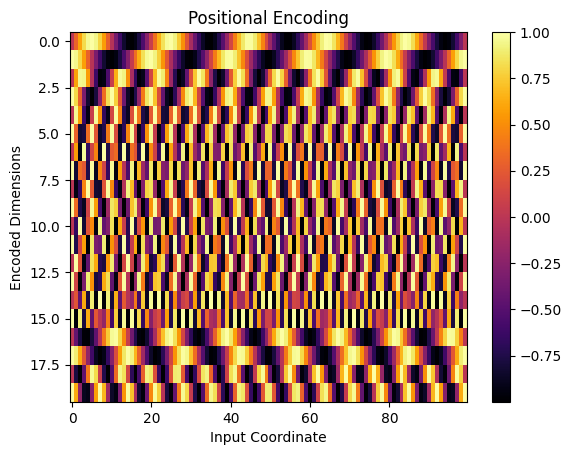

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def positional_encoding(p, L):
    encoded = []
    for i in range(L):
        for fn in [np.sin, np.cos]:
            encoded.append(fn(2**i * np.pi * p))
    return np.concatenate(encoded, axis=-1)

# Example input coordinate
p = np.linspace(0, 10, 100)
L = 10  # Number of frequency bands

# Generate positional encoding
encoding = positional_encoding(p[:, np.newaxis], L)

# Visualize the encoding
plt.imshow(encoding.T, aspect='auto', cmap='inferno')
plt.colorbar()
plt.title('Positional Encoding')
plt.xlabel('Input Coordinate')
plt.ylabel('Encoded Dimensions')
plt.show()


### Volumetric Rendering

The predictions from the MLP are integrated into classical volumetric rendering strategies. The goal is to accumulate the color along a ray as it passes through a volume. The accumulated color $ C(r)$ of a ray $ r(t) = \mathbf{o} + t\mathbf{d}$ is given by the following integral:

$$
C(r)= \int_{t_n}^{t_f} T(t) \cdot \sigma(r(t)) \cdot c(r(t), \mathbf{d}) \, dt
$$

where:
1. $ C(r)$ is the color assigned to the sampled point.
2. $ T(t)$ refers to the **transmittance** and is defined as:
   $$
   T(t) = \exp{\left(- \int_{t_n}^t \sigma(r(s)) \, ds \right)}
   $$
   This denotes the accumulated transmittance along the ray from $ t_n$ to $ t$, representing the probability that the ray travels from $ t_n$ to $ t$ without hitting any other particles.
3. $ r(t)$ is the generated ray.
4. $ \sigma(r(t))$ is the volume density, which can be interpreted as the probability of the ray terminating at point $ t$.
5. $ c(r(t), \mathbf{d})$ is the color of the ray at point $ t$, explicitly including the direction $\mathbf{d}$.

Thus, the color of an object in 3D space is defined as the sum of the transmittance, volume density, the color at the current point, and the direction of the sampled ray for all $ t \in (t_n, t_f)$ in the viewing plane.

**Note:** In NeRF, the authors mention: "We encourage the representation to be multiview-consistent by restricting the network to predict the volume density sigma as a function of only the location $ x$, while allowing the RGB color $ c$ to be predicted as a function of both location and viewing direction." Therefore, the term $ c(r(t), \mathbf{d})$ explicitly includes the direction $\mathbf{d}$.

#### Numerical Estimation

It is necessary to estimate $ C(r)$ using computational methods. The authors use an existing formulation from the literature (see [Ref](https://courses.cs.duke.edu/spring03/cps296.8/papers/max95opticalModelsForDirectVolumeRendering.pdf)). The formulation can be written as:

$$
\hat{C}(r) = \sum_{i=1}^{N} T_i \cdot \left(1 - \exp(-\sigma_i \delta_i) \right) \cdot c_i \\
\hat{C}(r) = \sum_{i=1}^{N} T_i \cdot \alpha_i \cdot c_i
$$

where:
- $ T_i = \exp\left(-\sum_{j=1}^{i-1} \sigma_j \delta_j \right)$
- $ \delta_i = t_{i+1} - t_i$ is the distance between adjacent samples.

This function to calculate $ \hat{C}(r)$ from the set of $(c_i, \sigma_i)$ is differentiable and reduces to traditional [**alpha compositing**](https://en.wikipedia.org/wiki/Alpha_compositing) with values:

$$
\alpha_i = 1 - \exp(-\sigma_i \delta_i)
$$


### Cost Function

The loss function used by NeRF is referred to as the photometric loss. It is calculated by comparing the colors of the synthesized image with the real image.

$$
L = \sum_{i=1}^{N} \left\| I_i - \widehat{I}_i \right\|_2^2 \\
\boldsymbol{\theta} = \arg\min_{\boldsymbol{\theta}} {L}
$$

where:
- $I_i$ is the $i$-th pixel color of the real image.
- $\widehat{{I}}_i$ is the $i$-th pixel color of the synthesized image.
- $N$ is the total number of pixels.

This loss function is differentiable, allowing us to optimize the model parameters $\boldsymbol{\theta}$ using **backpropagation**.

### Explanation

1. **Photometric Loss:**
   - The photometric loss measures the difference between the colors of the real image and the synthesized image. This difference is quantified using the L2 norm (Euclidean distance).
   - The summation over $N$ pixels ensures that the loss is computed for every pixel in the image, providing a comprehensive measure of the difference between the real and synthesized images.

2. **Optimization Objective:**
   - The goal of the training process is to find the model parameters $\boldsymbol{\theta}$ that minimize the photometric loss.
   - This is achieved by using gradient descent algorithms, which adjust the parameters $\boldsymbol{\theta}$ iteratively to reduce the loss.

3. **Differentiability:**
   - The loss function is differentiable, which is crucial for the backpropagation algorithm. Backpropagation computes the gradient of the loss function with respect to the model parameters, allowing the optimization algorithm to update the parameters in the direction that reduces the loss.

### Mathematical Formulation

The loss function can be expressed as:

$$
{L} = \sum_{i=1}^{N} \left( {I}_i - \widehat{{I}}_i \right)^2
$$

where ${I}_i$ and $\widehat{{I}}_i$ are the pixel values of the real and synthesized images, respectively.

The optimization objective is:

$$
\boldsymbol{\theta} = \arg\min_{\boldsymbol{\theta}} {L}
$$

This optimization problem is solved using gradient descent, which iteratively updates the model parameters:

$$
\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \eta \nabla_{\boldsymbol{\theta}} {L}
$$

where $\eta$ is the learning rate, and $\nabla_{\boldsymbol{\theta}} {L}$ is the gradient of the loss function with respect to the model parameters.
